# Imports

In [2]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from tqdm import tqdm
%matplotlib inline

# Helper functions

In [3]:
class Gridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)


        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - 0.75 * self.wind

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind / 4


        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if i in [0, self.grid_size-1, self.grid_size*10, self.grid_size**2-1]:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if min(xi+xj, yi+yj) < 0 or max(xi+xj, yi+yj) >= self.grid_size:
                # we have the regular success chance of staying here
                # plus an extra chance of blowing onto the *other* off-grid square
                return 1 - 0.5 * self.wind
            else:
                # We can blow off the grid in either direction only by wind.
                return 0.5 * self.wind
        else:
            # Not a corner. Is it an edge?
            if 0 < xi < self.grid_size-1 and 0 < yi < self.grid_size-1:
                return 0

            else:#it is an edge
                # we Can only move off the edge in one direction.
                # Did we intend to move off the grid?
                if min(xi+xj, yi+yj) < 0 or max(xi+xj, yi+yj) >= self.grid_size:
                    #we have the regular success chance of staying here.
                    return 1 - 0.75 * self.wind
                else:
                    # We can blow off the grid only by wind.
                    return self.wind / 4

    def reward(self, state_int=None, reward_type=1):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """
        #reward 1: fig 6
        reward = np.zeros((10,10), dtype=int)
        if reward_type == 1:
          reward[2, 5]=-10
          reward[2, 6]=-10
          reward[3, 5]=-10
          reward[3, 6]=-10

          reward[4, 1]=-10
          reward[4, 2]=-10
          reward[5, 1]=-10
          reward[5, 2]=-10

          reward[8, 2]=-10
          reward[8, 3]=-10
          reward[9, 2]=-10
          reward[9, 3]=-10

          reward[9,9]=1

        if reward_type == 2:
          reward[1, 4] = -100
          reward[1, 5] = -100
          reward[1, 6] = -100

          reward[2, 4] = -100
          reward[2, 6] = -100
          reward[3, 4] = -100
          reward[3, 6] = -100
          reward[4, 4] = -100
          reward[5, 4] = -100
          reward[6, 4] = -100

          reward[3, 7] = -100
          reward[3, 8] = -100
          reward[4, 8] = -100
          reward[5, 8] = -100
          reward[6, 8] = -100

          reward[7, 6] = -100
          reward[7, 7] = -100
          reward[7, 8] = -100

          reward[8, 6] = -100

          reward[9, 9] = 10


        if state_int is None:
          reward_states = np.zeros(self.n_states)
          for i in range(self.n_states):
              reward_states[i] = reward[self.int_to_point(i)]
          return reward_states
        else:
          xi, yi = self.int_to_point(state_int)
          return reward[xi,yi]

    def get_transition_matrix(self):
      p = np.zeros((self.n_states, self.n_actions, self.n_states))
      for state in range(self.n_states):
          for action in range(self.n_actions):
              p[state][action][self.next_state_after_action(state,action)] += 1 - self.wind
              for wind_action in range(self.n_actions):
                  p[state][action][self.next_state_after_action(state,wind_action)] += self.wind / 4
      return p

    def next_state_after_action(self, state, action):
        def is_state(state):
          return (state >= 0) and (state < 100)

        def is_action(action):
            return (action == 0 or action == 1 or action == 2 or action == 3)

        def is_row_state(state):
            return state % 10

        def is_column_state(state):
            return state // 10

        state_next = state

        if(action == 0):
            if(is_state(state-1) and (is_column_state(state-1) == is_column_state(state))):
                state_next= state - 1
        elif(action == 1):
            if(is_state(state+10) and (is_row_state(state+10) == is_row_state(state))):
                state_next = state + 10
        elif(action==2):
            if(is_state(state+1) and (is_column_state(state+1) == is_column_state(state))):
                state_next = state + 1
        elif(action == 3):
            if(is_state(state-10) and (is_row_state(state-10) == is_row_state(state))):
                state_next = state - 10

        return state_next

In [4]:
def optimal_value(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2, print_steps=True):
    """
    Find the optimal value function.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    -> Array of values for each state
    """

    v = np.zeros(n_states)

    delta = np.inf
    steps = 0
    while delta > threshold:
        steps += 1
        delta = 0

        for s in range(n_states):
            v_old = v[s]

            value_arr = np.zeros(n_actions)
            for a in range(n_actions):
                value = 0
                for s_next in range(n_states):
                    value += transition_probabilities[s][a][s_next] * (reward[s_next] + discount * v[s_next])
                value_arr[a] = value

            v[s] = np.max(value_arr)

            delta = max(delta, abs(v[s] - v_old))

    if print_steps:
        print(f"Number of states is {steps}")
    return v

def find_policy(n_states, n_actions, transition_probabilities, reward, discount,
                threshold=1e-2, v=None, stochastic=False):
    """
    Find the optimal policy.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    v: Value function (if known). Default None.
    stochastic: Whether the policy should be stochastic. Default True.
    -> Action probabilities for each state or action int for each state
        (depending on stochasticity).
    """

    if v is None:
        v = optimal_value(n_states, n_actions, transition_probabilities, reward,
                          discount, threshold, print_steps=False)

    def _policy(s):
        new_values = []
        for a in range(n_actions):
            new_values.append(np.dot(transition_probabilities[s][a],
                                        (reward + discount * v)))
        return np.argmax(new_values)

    policy = np.array([_policy(s) for s in range(n_states)])
    return policy

In [5]:
## Function for plotting the matrix values
def plot_matrix(matrix, float_format='{:.1f}', title=None):
    fig, ax = plt.subplots()
    num_rows = len(matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = matrix[i][j]
            ax.text(j + 0.5, i + 0.5, float_format.format(c), va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()


In [6]:
#redefining the gridworld to show in this question
grid_size = 10 #number of states = 100
wind = 0.1
discount = 0.8

# Make the gridworld and associated data.
gw = Gridworld(grid_size, wind, discount)

In [7]:
def heat_map_plot(matrix, title, float_format='{:.1f}'):
    plt.pcolor(np.flipud(matrix))
    for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
          plt.text(0.5+j, 9.5-i, float_format.format(matrix[i, j]),
                  ha='center', va='center', color='w')
    plt.colorbar()
    plt.axis('off')
    plt.title(title)
    plt.show()

In [8]:
def reward_grid_plot(reward_type, _title=None):
    reward_matrix = np.zeros((grid_size, grid_size))
    for j in range(grid_size):
        for i in range(grid_size):
            reward_matrix[i][j] = gw.reward(gw.point_to_int((i,j)), reward_type)
    plot_matrix(reward_matrix, title=_title)
    return reward_matrix

In [15]:
l = list(range(4))

# Question 10

In [17]:
def find_CDB(lambda_param, transition_probs, policy, discount, expert_reward):
    num_states = gw.n_states
    n_action = gw.n_actions
    action_list = list(range(n_action))

    expert_reward_max = np.max(np.abs(expert_reward))
    
    c = np.concatenate([np.ones((num_states, 1)), -lambda_param * np.ones((num_states, 1)), np.zeros((num_states, 1))])
    
    optimal_action_trans = np.zeros((num_states, num_states))
    action_trans = np.zeros((n_action - 1, num_states,num_states))
    
    for state in range(num_states):
        action_list = list(range(n_action))
        act = policy[state]
        optimal_action_trans[state, :] = transition_probs[state][act]
        action_list.remove(act)
        for i, action in enumerate(action_list):
            action_trans[i, state, :] = transition_probs[state][action]
            
    idn_matrix = np.eye(num_states) 
    zeros_matrix = np.zeros((num_states, num_states))
    
    for i in range(n_action - 1):
        current_action_trans = action_trans[i]
        row1 = np.hstack((idn_matrix, 
                          zeros_matrix, 
                          np.matmul(current_action_trans - optimal_action_trans, 
                                    np.linalg.inv(idn_matrix - discount * np.array(optimal_action_trans)))))
        row12 = np.vstack((row1, np.hstack((zeros_matrix, 
                                            zeros_matrix, 
                                            np.matmul(current_action_trans - optimal_action_trans, 
                                                      np.linalg.inv(idn_matrix - discount * np.array(optimal_action_trans)))))))
        if i == 0:
            D = row12.copy()
        else:
            D = np.vstack((D,row12))
            
    D = np.vstack((D, np.hstack((zeros_matrix, -idn_matrix, idn_matrix))))
    D = np.vstack((D, np.hstack((zeros_matrix, -idn_matrix, -idn_matrix))))
    D = np.vstack((D, np.hstack((zeros_matrix, zeros_matrix, idn_matrix))))
    D = np.vstack((D, np.hstack((zeros_matrix, zeros_matrix, -idn_matrix))))
    b = np.concatenate([np.zeros((2 * (n_action - 1) * num_states + 2 * num_states,)), expert_reward_max * np.ones((2 * num_states,))])

    return matrix(c), matrix(D), matrix(b)

## Report

## Inverse Reinforcement Learning — Question 10

<!---- cost / penalty vector -->
$$
\mathbf{c} \;=\;
\begin{bmatrix}
\mathbf{1}_{|S|\times 1}\\[4pt]
-\lambda \,\mathbf{1}_{|S|\times 1}\\[4pt]
\mathbf{0}_{|S|\times 1}
\end{bmatrix},
\qquad
\mathbf{x} \;=\;
\begin{bmatrix}
t\\ u\\ R
\end{bmatrix}
$$

<!---- demonstration matrix -->
$$
\mathbf{D} \;=\;
\begin{bmatrix}
I_{|S|\times|S|} & 0 & \bigl(P_{a} - P_{a_1}\bigr)\!\left(I-\gamma P_{a_1}\right)^{-1} \\[6pt]
0 & 0 & \bigl(P_{a} - P_{a_1}\bigr)\!\left(I-\gamma P_{a_1}\right)^{-1} \\[6pt]
0 & -I_{|S|\times|S|} &  \;I_{|S|\times|S|} \\[6pt]
0 & -I_{|S|\times|S|} & -I_{|S|\times|S|} \\[6pt]
0 & 0 &  \;I_{|S|\times|S|} \\[6pt]
0 & 0 & -I_{|S|\times|S|}
\end{bmatrix}
$$

<!---- behaviour / constraint vector -->
$$
\mathbf{b} \;=\;
\begin{bmatrix}
\mathbf{0}_{|S|\times 1}\\[4pt]
\mathbf{0}_{|S|\times 1}\\[4pt]
\mathbf{0}_{|S|\times 1}\\[4pt]
\mathbf{0}_{|S|\times 1}\\[4pt]
(R_{\max})_{|S|\times 1}\\[4pt]
(R_{\max})_{|S|\times 1}
\end{bmatrix}
$$


# Question 11

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

In [53]:
class IRL:
    def __init__(self, transition_probs, expert_reward, discount=0.8, epsilon=0.01, wind=0.1, vectorized=True):
        self.transition_probs = transition_probs
        self.expert_reward = expert_reward
        self.max_reward = np.argmax(np.abs(expert_reward))
        self.discount = discount
        self.epsilon = epsilon
        self.wind = wind
        self.vectorized = vectorized
        
        self.num_states = gw.n_states
        self.num_actions = gw.n_actions
        self.learned_rewards, self.learned_policy, self.learned_value = None, None, None
    
        if vectorized:
            self.expert_value, self.expert_policy = self.find_value_policy(expert_reward)
        else:
            self.expert_value, self.expert_policy = self.find_value_policy_Q5(expert_reward)

    def find_CDB(self, lambda_param):
        action_list = list(range(self.num_actions))

        expert_reward_max = np.max(np.abs(self.expert_reward))
        
        c = np.concatenate([np.ones((self.num_states, 1)), -lambda_param * np.ones((self.num_states, 1)), np.zeros((self.num_states, 1))])
        
        optimal_action_trans = np.zeros((self.num_states, self.num_states))
        action_trans = np.zeros((self.num_actions - 1, self.num_states, self.num_states))
        
        for state in range(self.num_states):
            action_list = list(range(self.num_actions))
            act = self.expert_policy[state]
            optimal_action_trans[state, :] = self.transition_probs[state][act]
            action_list.remove(act)
            for i, action in enumerate(action_list):
                action_trans[i, state, :] = self.transition_probs[state][action]
                
        idn_matrix = np.eye(self.num_states) 
        zeros_matrix = np.zeros((self.num_states, self.num_states))
        
        for i in range(self.num_actions - 1):
            current_action_trans = action_trans[i]
            row1 = np.hstack((idn_matrix, 
                            zeros_matrix, 
                            np.matmul(current_action_trans - optimal_action_trans, 
                                        np.linalg.inv(idn_matrix - self.discount * np.array(optimal_action_trans)))))
            row12 = np.vstack((row1, np.hstack((zeros_matrix, 
                                                zeros_matrix, 
                                                np.matmul(current_action_trans - optimal_action_trans, 
                                                        np.linalg.inv(idn_matrix - self.discount * np.array(optimal_action_trans)))))))
            if i == 0:
                D = row12.copy()
            else:
                D = np.vstack((D,row12))
                
        D = np.vstack((D, np.hstack((zeros_matrix, -idn_matrix, idn_matrix))))
        D = np.vstack((D, np.hstack((zeros_matrix, -idn_matrix, -idn_matrix))))
        D = np.vstack((D, np.hstack((zeros_matrix, zeros_matrix, idn_matrix))))
        D = np.vstack((D, np.hstack((zeros_matrix, zeros_matrix, -idn_matrix))))
        b = np.concatenate([np.zeros((2 * (self.num_actions - 1) * self.num_states + 2 * self.num_states,)), expert_reward_max * np.ones((2 * self.num_states,))])

        return matrix(c), matrix(D), matrix(b)
    
    def find_value_policy(self, rewards, print_steps=False):
        value_function = np.zeros((self.num_states,))
        delta = np.inf
        step = 0
        while delta > self.epsilon:
            if print_steps:
                step += 1
            old_value = value_function
            value_function = np.amax(np.matmul(self.transition_probs, rewards + self.discount * value_function), axis=1)
            delta = np.amax(np.abs(old_value - value_function))
            
        policy = np.argmax(np.matmul(self.transition_probs, rewards + self.discount * value_function), axis=1)
        if print_steps:
            print(f"Number of steps: {step}")
        
        return value_function, policy
    
    def find_value_policy_Q5(self, reward, v=None, stochastic=False, _print_steps=False):
        n_states = self.num_states
        n_actions = self.num_actions
        transition_probabilities = self.transition_probs
        discount = self.discount
        threshold = self.epsilon
        if v is None:
            v = optimal_value(n_states, n_actions, transition_probabilities, reward,
                            discount, threshold, print_steps=_print_steps)

        def _policy(s):
            new_values = []
            for a in range(n_actions):
                new_values.append(np.dot(transition_probabilities[s][a],
                                            (reward + discount * v)))
            return np.argmax(new_values)

        policy = np.array([_policy(s) for s in range(n_states)])
        return v, policy
    
    def solve(self, lambda_param, _print_steps=False):
        solvers.options['show_progress'] = False
        c, D, b = self.find_CDB(lambda_param)
        solution = solvers.lp(-c, D, b)
        self.learned_rewards = np.array(solution['x'][-self.num_states:]).squeeze()
        if self.vectorized:
            self.learned_value, self.learned_policy = self.find_value_policy(self.learned_rewards, print_steps=_print_steps)
        else:
            self.learned_value, self.learned_policy = self.find_value_policy_Q5(self.learned_rewards)
        
        return self.learned_rewards, self.learned_policy, self.learned_value
    
    def compute_accuray(self, expert, predicted):
        accuracy = np.mean(expert == predicted)
        return accuracy
    
    def evaluate(self, lambda_values):
        accuracies = []
        for lambda_param in tqdm(lambda_values):
            self.solve(lambda_param)
            accuracy = self.compute_accuray(self.expert_policy, self.learned_policy)
            accuracies.append(accuracy)
        return np.array(accuracies)
    
    def plot_accuracy(self, lambda_values, accuracies, title=None):
        plt.figure(figsize=(10, 6))
        plt.plot(lambda_values, accuracies)
        plt.xlabel('$\lambda$')
        plt.ylabel('Accuracy')
        plt.title(f'Policy Accuracy vs Lambda {title}')
        plt.grid(True)
        plt.show()

<>:128: SyntaxWarning: invalid escape sequence '\l'
<>:128: SyntaxWarning: invalid escape sequence '\l'
/var/folders/r_/4q119ss54y72rlcb31vm9ghw0000gn/T/ipykernel_1174/2104519900.py:128: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


In [10]:
irl_solver = IRL(
    transition_probs=gw.get_transition_matrix(),
    expert_reward=gw.reward(reward_type=1),         
    discount=0.8,
    wind = 0.1,
    epsilon=0.01
)

In [15]:
irl_solver_Q5 = IRL(
    transition_probs=gw.get_transition_matrix(),
    expert_reward=gw.reward(reward_type=1),         
    discount=0.8,
    wind = 0.1,
    epsilon=0.01,
    vectorized=False
)

In [23]:
# comparing the differnce of using find_value_policy and find_value_policy from Q5
expert_opt_value = irl_solver.expert_value
expert_opt_value_Q5 = irl_solver_Q5.expert_value
print(np.mean(expert_opt_value -expert_opt_value_Q5))

-0.0020632641637533407


100%|██████████| 500/500 [03:03<00:00,  2.73it/s]


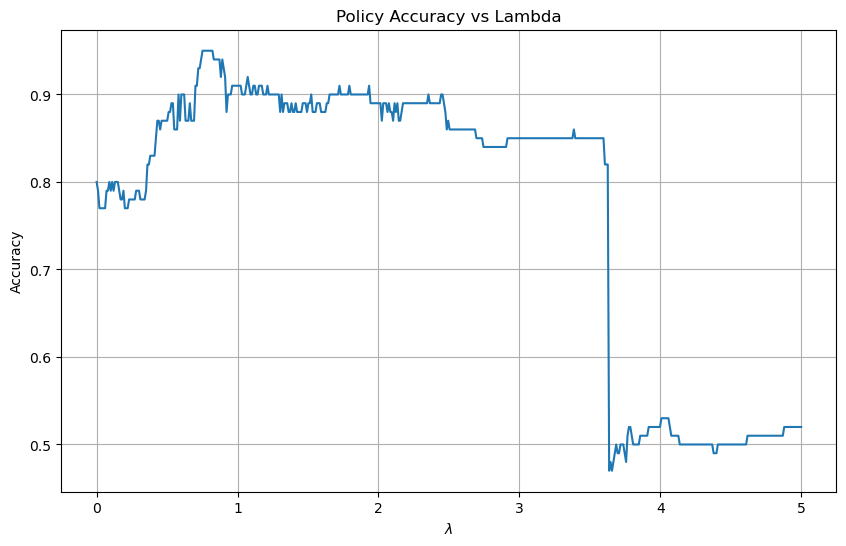

In [29]:
lambda_values = np.linspace(0, 5, 500)
accuracies = irl_solver.evaluate(lambda_values)
irl_solver.plot_accuracy(lambda_values, accuracies)

 **This plot is when we use the find_policy_value from Q5:**

In [ ]:
lambda_values = np.linspace(0, 5, 500)
accuracies_Q5 = irl_solver_Q5.evaluate(lambda_values)

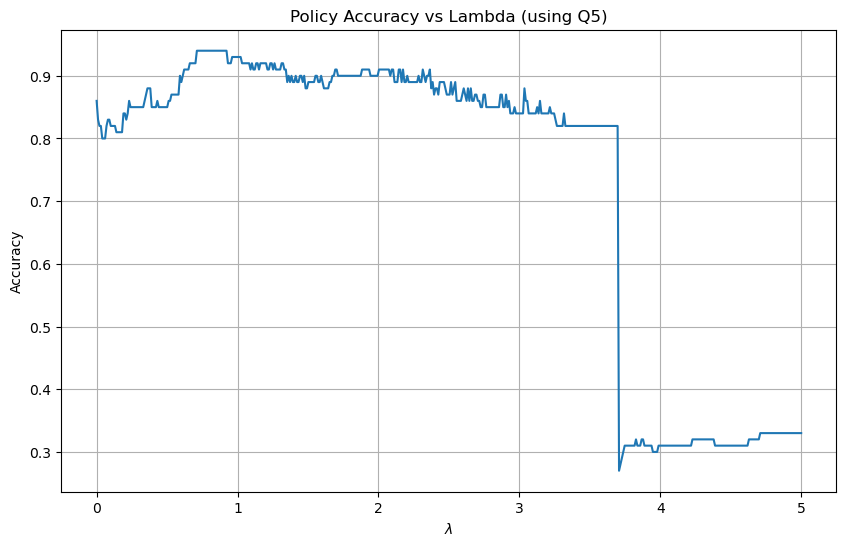

In [36]:
# Attention: This plot is for observations and comparisons

irl_solver_Q5.plot_accuracy(lambda_values, accuracies_Q5, title="(using Q5)")

## Report

**Attention: The first plot is the main plot and the second plot is for the comparison and observations!**



# Question 12

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

In [40]:
lamda_max = lambda_values[np.argmax(accuracies)]
print(f"Lambda max is: {lamda_max}")

Lambda max is: 0.751503006012024


In [41]:
lamda_max_Q5 = lambda_values[np.argmax(accuracies_Q5)]
print(f"Lambda max when using find_policy_value from Q5 is: {lamda_max_Q5}")

Lambda max when using find_policy_value from Q5 is: 0.7114228456913827


## Report

The lambda with maximum accuracy is 0.75. When using the value iterations from Q5, it is 0.71.

# Question 13

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

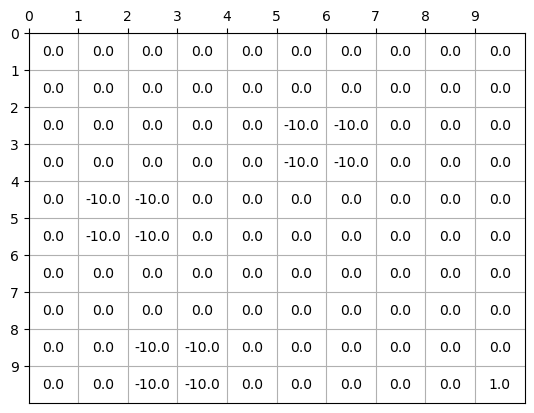

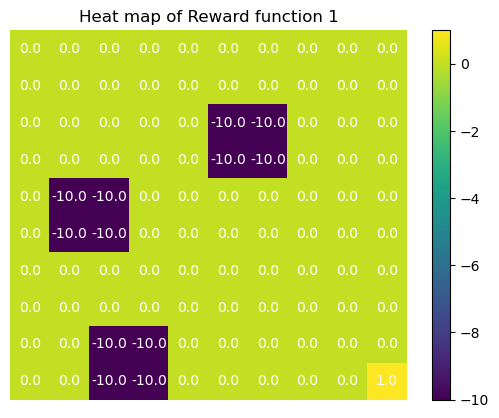

In [48]:
reward_matrix_1 = reward_grid_plot(reward_type=1)
heat_map_plot(reward_matrix_1, title=f'Heat map of Reward function 1')

In [ ]:
reward_predicted_lambda_max, policy_predicted_lambda_max, value_predicted_lambda_max = irl_solver.solve(lamda_max)

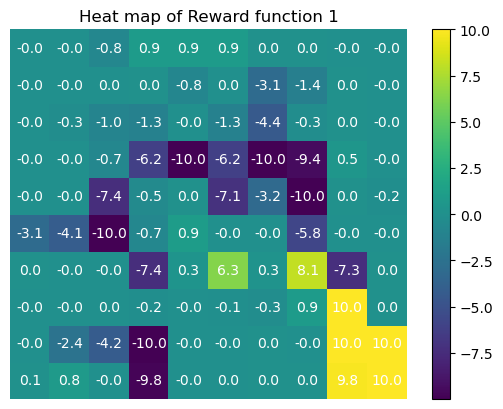

In [52]:
heat_map_plot(reward_predicted_lambda_max.reshape(10, 10, order='F'), title=f'Heat map of Reward function 1')

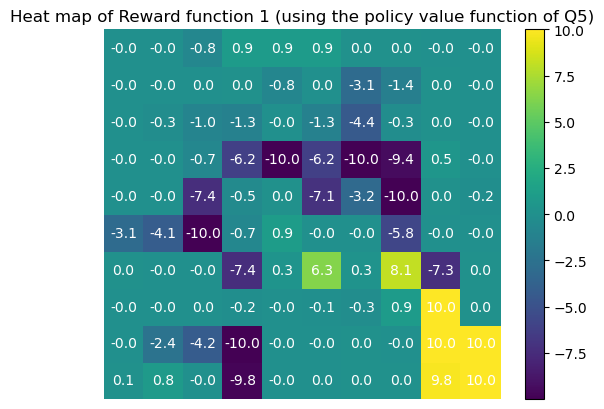

In [67]:
reward_predicted_lambda_max_Q5, policy_predicted_lambda_max_Q5, value_predicted_lambda_max_5 = irl_solver_Q5.solve(lamda_max)
heat_map_plot(reward_predicted_lambda_max.reshape(10, 10, order='F'), title=f'Heat map of Reward function 1 (using the policy value function of Q5)')

## Report

The predicted reward is in the range -10 to 10. 

The meat maps are similar to eachother in regard of approsimate location the goal states and the trap states. 

Sharp penalty regions are not present in the predicted map, and only a few states have strongly negative values.

Penalty and reward regions are smoothed, but the traps and goal states are observable. 

The predicted reward have more high-reward states, and the pattern of negative rewards is not exactly like the expert’s rectangular regions. However, at the positions of those rectangles we still see negative rewards in the predicted map.

# Question 14

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

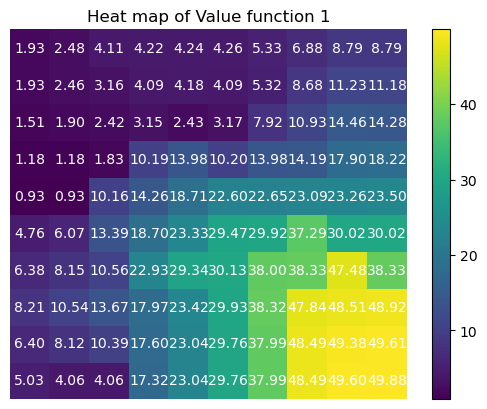

In [13]:
heat_map_plot(value_predicted_lambda_max.reshape(10, 10, order='F'), title=f'Heat map of Value function 1', float_format='{:.2f}')

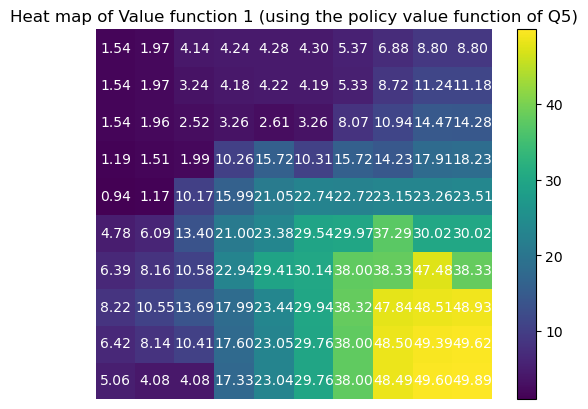

In [17]:
heat_map_plot(value_predicted_lambda_max_5.reshape(10, 10, order='F'), title=f'Heat map of Value function 1 (using the policy value function of Q5)', float_format='{:.2f}')

# Report

The figures shows the optimal state values. Same method used in Q 3 applies here. Lambda is set to lmabda_maximum and the reward is the predicted reward. 

The values are more near the goal state with a smooth transition to low values when going far from the goal state. 

All values are positive. 

# Question 15

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

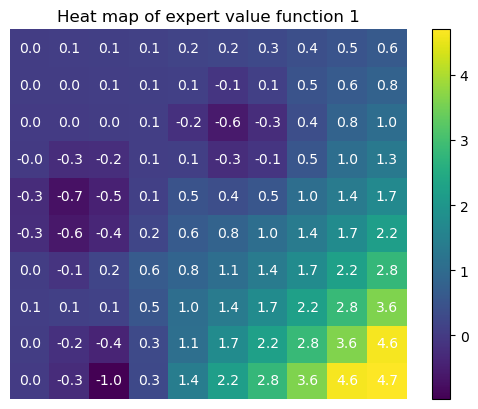

In [70]:
heat_map_plot(irl_solver.expert_value.reshape(10, 10, order='F'), title=f'Heat map of expert value function 1')

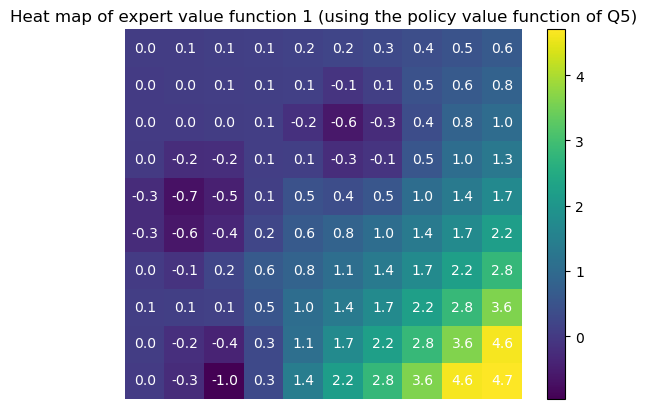

In [71]:
heat_map_plot(irl_solver_Q5.expert_value.reshape(10, 10, order='F'), title=f'Heat map of expert value function 1 (using the policy value function of Q5)')

In [18]:
# range of expert value
print("Range of predicted value:", np.min(value_predicted_lambda_max), "to", np.max(value_predicted_lambda_max))
print("Range of expert value:", np.min(irl_solver.expert_value), "to", np.max(irl_solver.expert_value))
print("\nRange of predicted value (Q5):", np.min(value_predicted_lambda_max_5), "to", np.max(value_predicted_lambda_max_5))
print("Range of expert value (Q5):", np.min(irl_solver_Q5.expert_value), "to", np.max(irl_solver_Q5.expert_value))


Range of predicted value: 0.9262416657884667 to 49.88362739186704
Range of expert value: -0.9817405144538256 to 4.701700670123254

Range of predicted value (Q5): 0.9378351809294717 to 49.88693341613744
Range of expert value (Q5): -0.9635874624130234 to 4.70154000635509


## Report

When comparing the expert-value heatmap with the predicted-agent-value heatmap, we observe similar regions of low and high values. The similarity is because both display higher values near goal states and lower values near traps. But the similarity is not exactly identical.

In the predicted-value map, the reward and penalty rectangles are not easily distinguishable.

Values increase as states reaches the lower right corner.

The ranges differ, as shown in the above box. The range differs due to discrepancies in reward values for certain states.

The expert-value map is smoother.

We observe more predicted states with very high values and more with very low values in the predicted value.

Reward and trap rectangles cannot be distinguished in the predicted map.

# Question 16, Question 17 (figures)

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

In [101]:
def plot_policy(policy, title="Policy Plot"):
    """
    Plot the policy as arrows on a 10x10 grid with arrows centered in each cell
    
    Args:
        policy: 1D array of length 100 containing actions (0-3)
        title: Title for the plot
    """
    policy_grid = policy.reshape(10, 10, order='F')
    
    fig, ax = plt.subplots()
    arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    
    for i in range(11):
        ax.axhline(y=i, color='black', linestyle='-')
        ax.axvline(x=i, color='black', linestyle='-')
    
    for i in range(10):
        for j in range(10):
            action = policy_grid[i,j]
            ax.text(j + 0.5, 9.5 - i, arrows[action], 
                   ha='center', va='center')
    
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_title(title)
    plt.show()

def compare_policies(policy1, policy2, title, policy1_label, policy2_label):
    policy1_grid = policy1.reshape(10, 10, order='F')
    policy2_grid = policy2.reshape(10, 10, order='F')
    
    fig, ax = plt.subplots()
    arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    
    for i in range(11):
        ax.axhline(y=i, color='black', linestyle='-')
        ax.axvline(x=i, color='black', linestyle='-')
    
    for i in range(10):
        for j in range(10):
            action1 = policy1_grid[i,j]
            action2 = policy2_grid[i,j]
            if action1 != action2:
                ax.add_patch(plt.Rectangle((j, 9-i), 1, 1, fc='red'))
            
            ax.text(j + 0.35, 9.5 - i, arrows[action1], 
                   ha='center', va='center', color='blue')
            ax.text(j + 0.65, 9.5 - i, arrows[action2], 
                   ha='center', va='center', color='green')
    
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_title(title)
    
    blue_patch = plt.Rectangle((0, 0), 1, 1, fc="blue", label=policy1_label)
    green_patch = plt.Rectangle((0, 0), 1, 1, fc="green", label=policy2_label)
    
    ax.legend(handles=[blue_patch, green_patch], 
             loc='upper center', bbox_to_anchor=(0.5, -0.1),
             ncol=2, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()




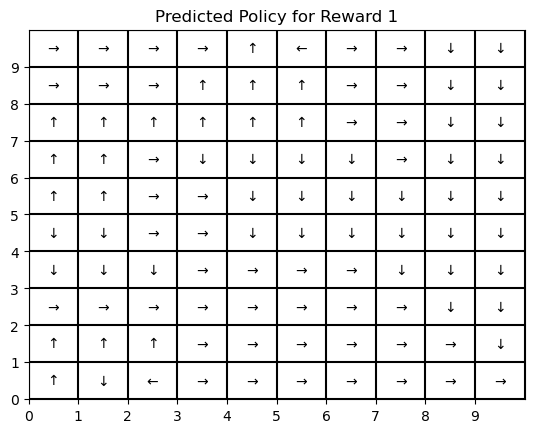

In [90]:
plot_policy(policy_predicted_lambda_max, title="Predicted Policy for Reward 1")

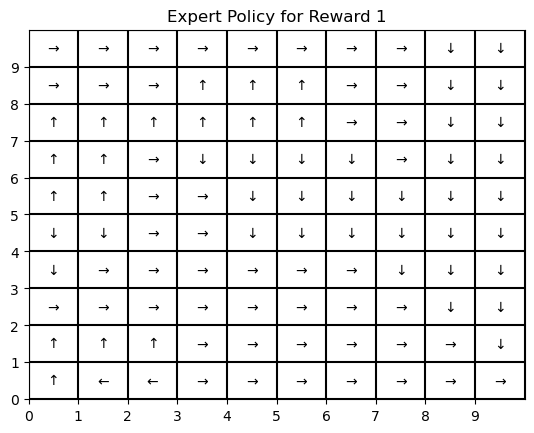

In [91]:
plot_policy(irl_solver.expert_policy, title="Expert Policy for Reward 1")

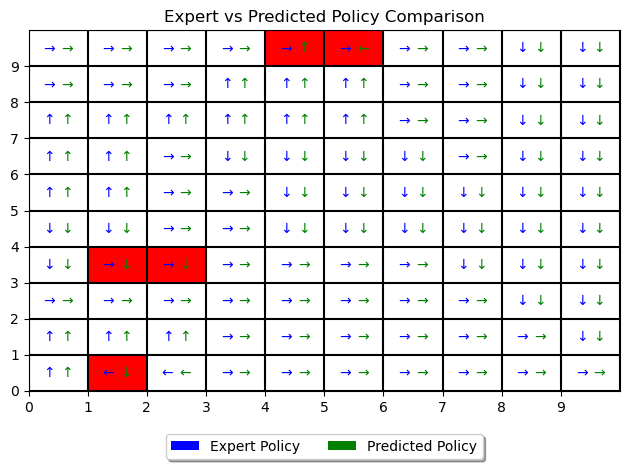

In [102]:
compare_policies(irl_solver.expert_policy, policy_predicted_lambda_max, 
                title="Expert vs Predicted Policy Comparison",
                policy1_label="Expert Policy",
                policy2_label="Predicted Policy")

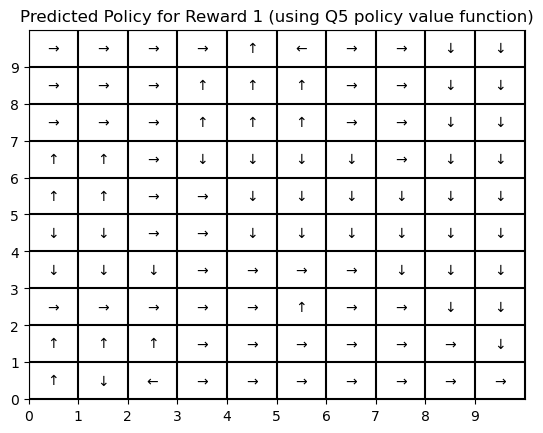

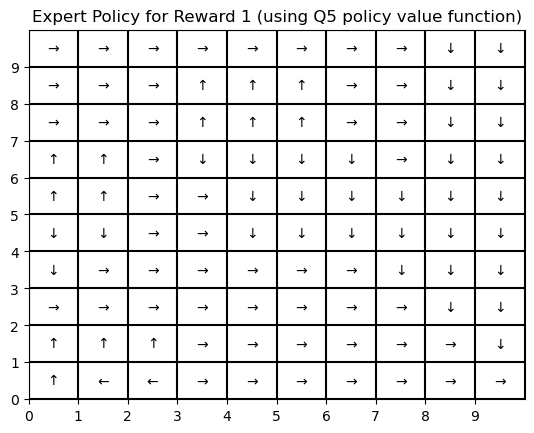

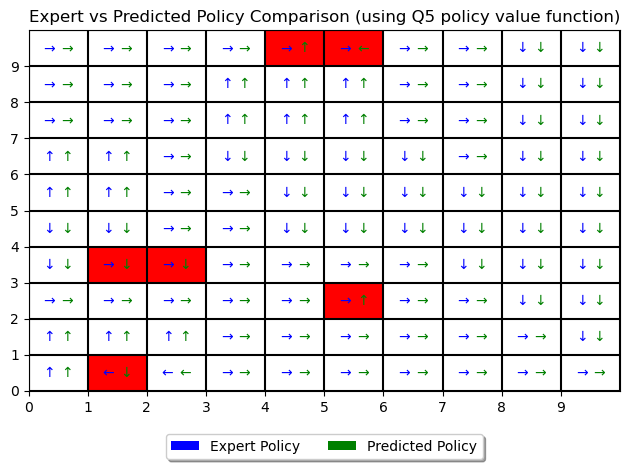

In [105]:
plot_policy(policy_predicted_lambda_max_Q5, title="Predicted Policy for Reward 1 (using Q5 policy value function)")
plot_policy(irl_solver_Q5.expert_policy, title="Expert Policy for Reward 1 (using Q5 policy value function)")
compare_policies(irl_solver_Q5.expert_policy, policy_predicted_lambda_max_Q5, 
                title="Expert vs Predicted Policy Comparison (using Q5 policy value function)",
                policy1_label="Expert Policy",
                policy2_label="Predicted Policy")

# Question 17

# Report

The states with different policies are highlighted in red.

We observe that most state policies are similar, even though the value and reward functions differ.

Both policies guide the agent to the goal by moving right and down wherever appropriate (in most of the states for the predicted one).

In states where the policies diverge, the predicted agent’s policy directs the agent away from the goal. This occurs because the predicted reward function have more trap states with negative rewards. Consequently, the agent prefers to stay near the edges to avoid those traps. This can be observed in the bottom left or upper part.

In some states the predicted reward does not penalize the agent as strongly or in the same pattern as the expert reward. Therefore, the agent may mistakenly choose to enter those states. For example, within the trap region not all negative rewards are -10.


# Question 18

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

-0.005625618879898355


100%|██████████| 500/500 [03:00<00:00,  2.76it/s]


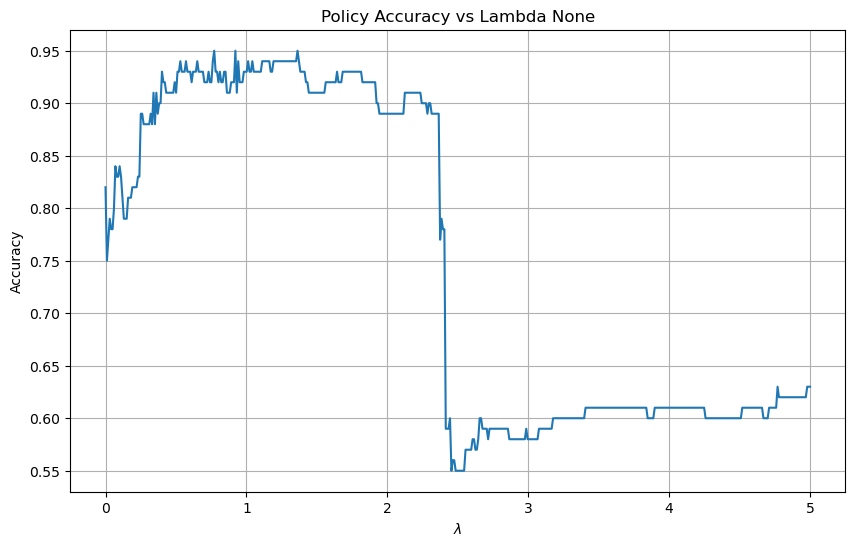

In [106]:
irl_solver_r2 = IRL(
    transition_probs=gw.get_transition_matrix(),
    expert_reward=gw.reward(reward_type=2),         
    discount=0.8,
    wind = 0.1,
    epsilon=0.01)

irl_solver_Q5_r2 = IRL(
    transition_probs=gw.get_transition_matrix(),
    expert_reward=gw.reward(reward_type=2),         
    discount=0.8,
    wind = 0.1,
    epsilon=0.01,
    vectorized=False
)

# comparing the differnce of using find_value_policy and find_value_policy from Q5
expert_opt_value_r2 = irl_solver_r2.expert_value
expert_opt_value_Q5_r2 = irl_solver_Q5_r2.expert_value
print(np.mean(expert_opt_value_r2 -expert_opt_value_Q5_r2))

lambda_values = np.linspace(0, 5, 500)
accuracies_r2 = irl_solver_r2.evaluate(lambda_values)
irl_solver_r2.plot_accuracy(lambda_values, accuracies_r2)


In [107]:
lambda_values = np.linspace(0, 5, 500)
accuracies_Q5_r2 = irl_solver_Q5_r2.evaluate(lambda_values)

100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


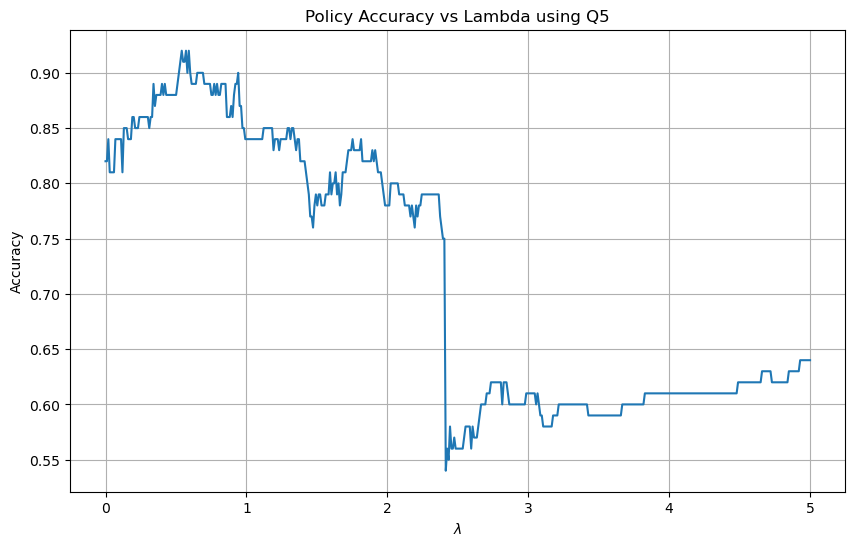

In [108]:
irl_solver_Q5_r2.plot_accuracy(lambda_values, accuracies_Q5_r2, title="using Q5")

# Question 19

In [112]:
lamda_max_r2 = lambda_values[np.argmax(accuracies_r2)]
print(f"Lambda max is: {lamda_max}")

Lambda max is: 0.7715430861723447


# Question 20

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

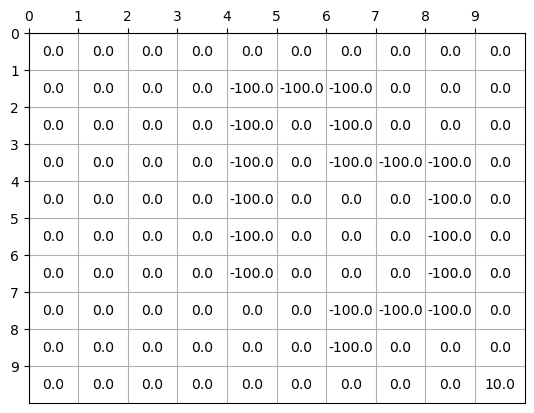

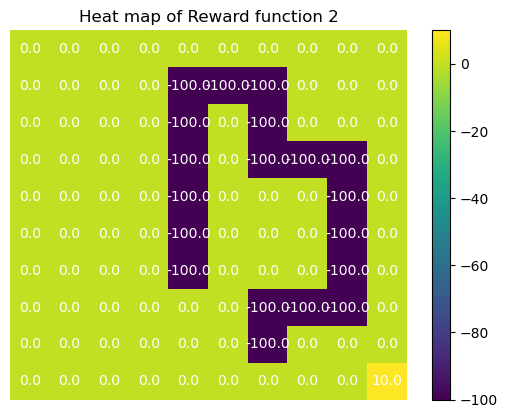

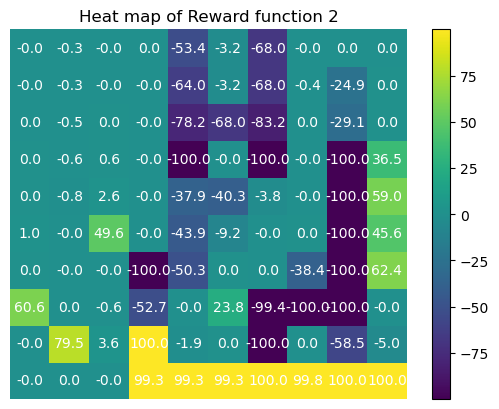

In [113]:
reward_matrix_2 = reward_grid_plot(reward_type=2)
heat_map_plot(reward_matrix_2, title=f'Heat map of Reward function 2')
reward_predicted_lambda_max_r2, policy_predicted_lambda_max_r2, value_predicted_lambda_max_r2 = irl_solver_r2.solve(lamda_max_r2)
heat_map_plot(reward_predicted_lambda_max_r2.reshape(10, 10, order='F'), title=f'Heat map of Reward function 2')

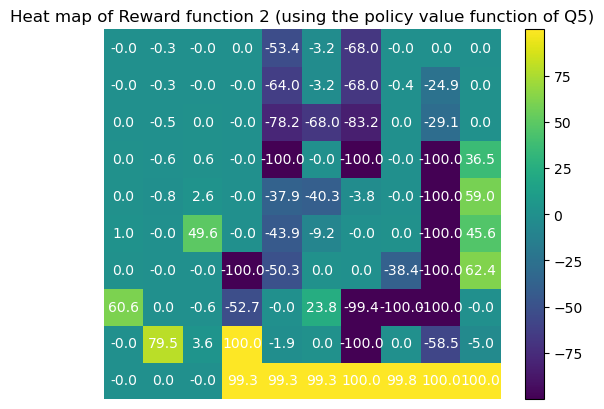

In [114]:
reward_predicted_lambda_max_Q5_r2, policy_predicted_lambda_max_Q5_r2, value_predicted_lambda_max_5_r2 = irl_solver_Q5_r2.solve(lamda_max_Q5_r2)
heat_map_plot(reward_predicted_lambda_max_r2.reshape(10, 10, order='F'), title=f'Heat map of Reward function 2 (using the policy value function of Q5)')

## Report

The extracted reward function gives more states to both high and low reward values. However, some of those states are not the maximum or minum reward (they are not exatcly -100 for example).

The overall scale of rewards differs from the expert function.

The trap regions appear in approximately the same locations. However, we see a few additional states also receive negative rewards.

The predicted reward is smoother overall, and fewer states have a reward of exactly zero.

# Question 21

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

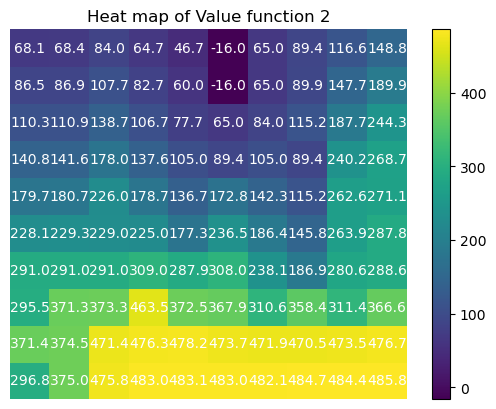

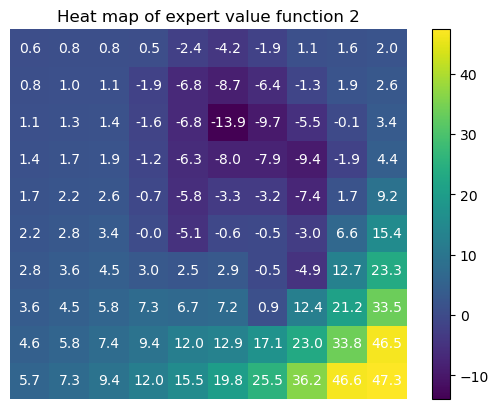

In [25]:
heat_map_plot(value_predicted_lambda_max_r2.reshape(10, 10, order='F'), title=f'Heat map of Value function 2', float_format='{:.1f}')
heat_map_plot(irl_solver_r2.expert_value.reshape(10, 10, order='F'), title=f'Heat map of expert value function 2')

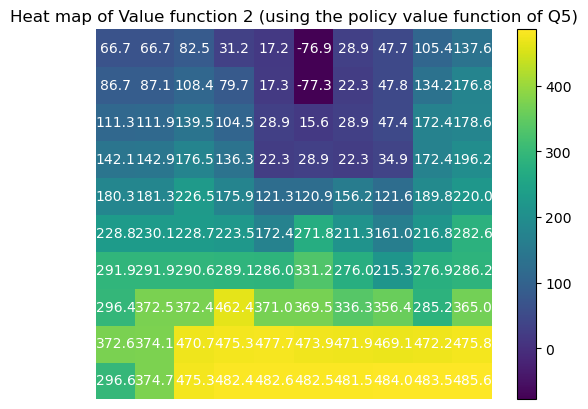

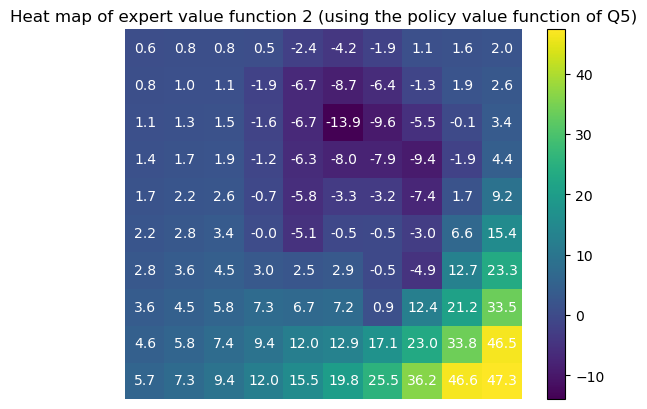

In [24]:
heat_map_plot(value_predicted_lambda_max_5_r2.reshape(10, 10, order='F'), title=f'Heat map of Value function 2 (using the policy value function of Q5)', float_format='{:.1f}')
heat_map_plot(irl_solver_Q5_r2.expert_value.reshape(10, 10, order='F'), title=f'Heat map of expert value function 2 (using the policy value function of Q5)')


In [26]:
# range of expert value
print("Range of predicted value:", np.min(value_predicted_lambda_max_r2), "to", np.max(value_predicted_lambda_max_r2))
print("Range of expert value:", np.min(irl_solver_r2.expert_value), "to", np.max(irl_solver_r2.expert_value))
print("\nRange of predicted value (Q5):", np.min(value_predicted_lambda_max_5_r2), "to", np.max(value_predicted_lambda_max_5_r2))
print("Range of expert value (Q5):", np.min(irl_solver_Q5_r2.expert_value), "to", np.max(irl_solver_Q5_r2.expert_value))


Range of predicted value: -16.02992957328045 to 485.79773557757443
Range of expert value: -13.91663457105861 to 47.31147106800797

Range of predicted value (Q5): -77.262223887685 to 485.60922796549727
Range of expert value (Q5): -13.911181835195762 to 47.31503150756767


# Question 22

## Report

The expert and predicted state value heatmaps are presented above.

The area of high and low values are similar approximately. However, the low-value region's location in the predicted one is upper. The reason is that the predicted reward shows low and negative rewards in that locations while they are not present in the expert's value map.

Both of them are smooth.

The number of high state values is more in the predicted one. Overall, the value distribution is different. 

The scale is also differnt. The details about the scale range has been provided above.

The expert's value heatmap also shows symmetrical pattern, but the predicted one deas not.

Overall, the predicted value reflects the noicy reward prediction and although there are similarities, the differences are observable.

# Question 23

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

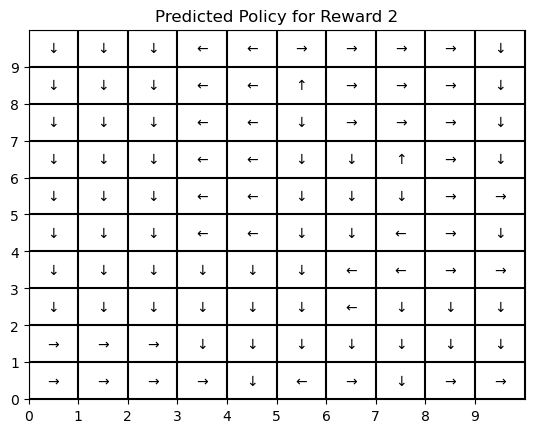

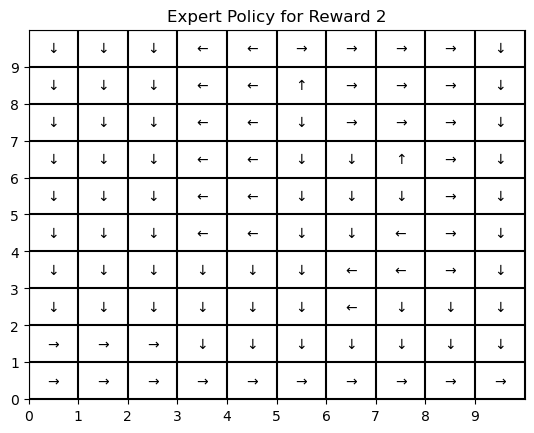

In [120]:
plot_policy(policy_predicted_lambda_max_r2, title="Predicted Policy for Reward 2")
plot_policy(irl_solver_r2.expert_policy, title="Expert Policy for Reward 2")

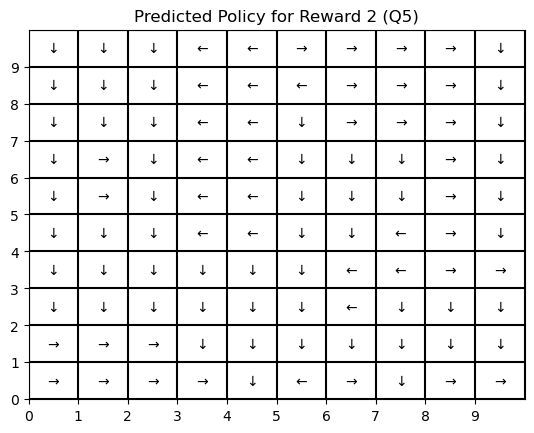

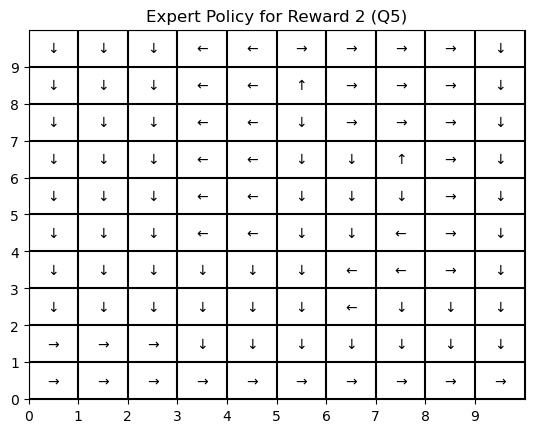

In [124]:
plot_policy(policy_predicted_lambda_max_Q5_r2, title="Predicted Policy for Reward 2 (Q5)")
plot_policy(irl_solver_Q5_r2.expert_policy, title="Expert Policy for Reward 2 (Q5)")

# Question 24

**Important Note: the find_value_policy is written uses vectorized computing. As a result is more efficient and its cumulative error is lower. I have used the implementation of the Q5 as well. While their final values are not differnt that much, the second method (find_value_policy_Q5) has more cumulative error. I have reported both of them's output, however, the ones that I have not used Q5 for are more accurate!**

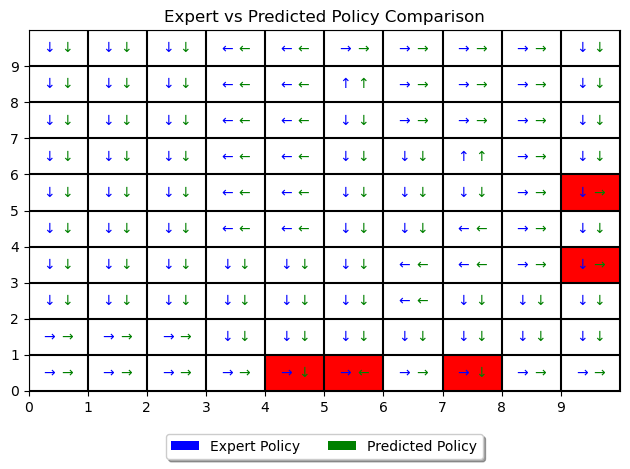

In [125]:
compare_policies(irl_solver_r2.expert_policy, policy_predicted_lambda_max_r2, 
                title="Expert vs Predicted Policy Comparison",
                policy1_label="Expert Policy",
                policy2_label="Predicted Policy")

**P.S: The 0, 0 state is still top left.**

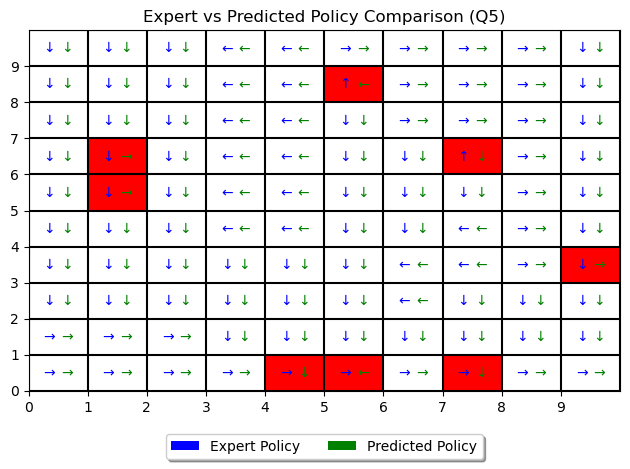

In [122]:
compare_policies(irl_solver_Q5_r2.expert_policy, policy_predicted_lambda_max_Q5_r2, 
                title="Expert vs Predicted Policy Comparison (Q5)",
                policy1_label="Expert Policy",
                policy2_label="Predicted Policy")



**P.S: The 0, 0 state is still top left.**

## Report

Most states have similar policies and those differns have been shown in red. 

The agent in both tries to reach the goal state and escape fromn the states with negative rewards.

The states with differnt polices are in in the edge or near the edge. Also, in that states, the predicted policy makes the agent move toward the edge and off-grid or away from the goal state. The reason is that according to the value plot and reward plot for the predicted one, we have more states that are local optimum, but they are not our goal state and we have more states with higher rewards and values. 

# Question 25

epsilon == 0.0001

100%|██████████| 500/500 [03:04<00:00,  2.72it/s]


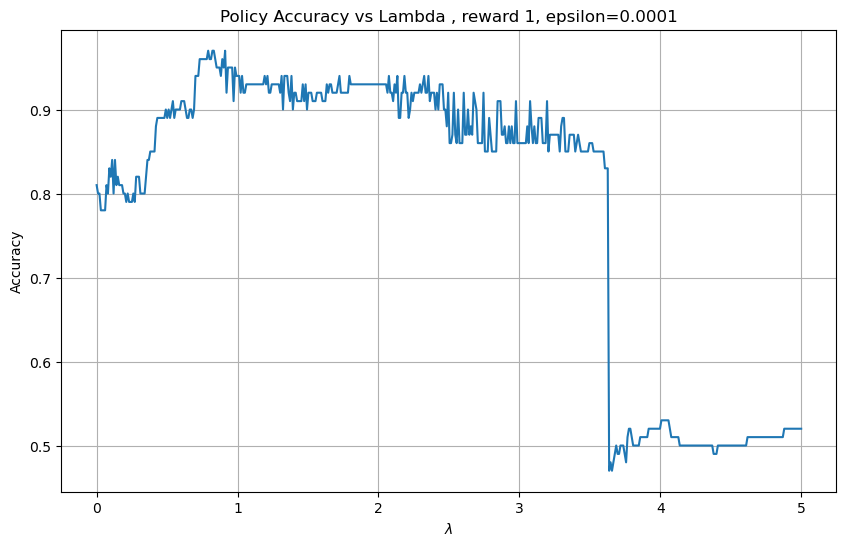

100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


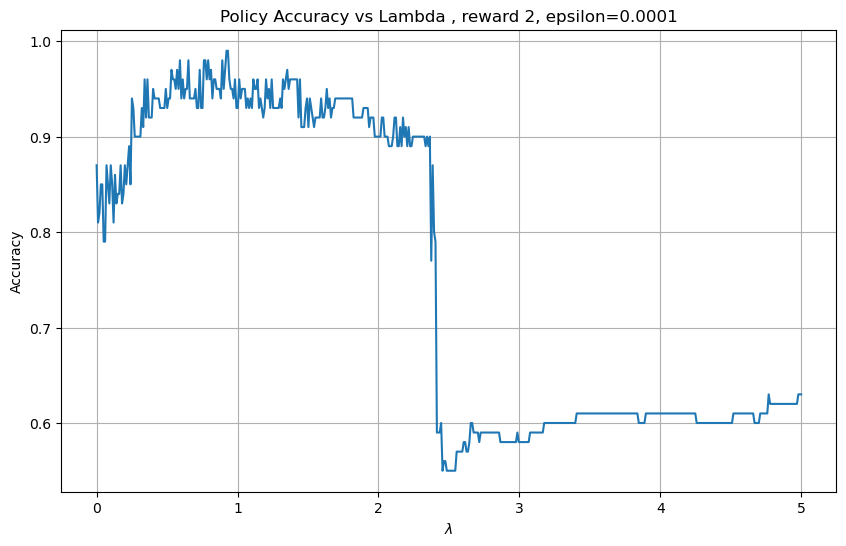

In [132]:
irl_solver = IRL(
    transition_probs=gw.get_transition_matrix(),
    expert_reward=gw.reward(reward_type=1),         
    discount=0.8,
    wind = 0.1,
    epsilon=0.0001)

irl_solver_r2 = IRL(
    transition_probs=gw.get_transition_matrix(),
    expert_reward=gw.reward(reward_type=2),         
    discount=0.8,
    wind = 0.1,
    epsilon=0.0001)

# comparing the differnce of using find_value_policy and find_value_policy from Q5
# For reward type 1
expert_opt_value = irl_solver.expert_value
expert_opt_value_Q5 = irl_solver_Q5.expert_value
#print("Reward type 1 difference:", np.mean(expert_opt_value - expert_opt_value_Q5))

lambda_values = np.linspace(0, 5, 500)
accuracies = irl_solver.evaluate(lambda_values)
irl_solver.plot_accuracy(lambda_values, accuracies, title=", reward 1, epsilon=0.0001")

# For reward type 2
expert_opt_value_r2 = irl_solver_r2.expert_value
expert_opt_value_Q5_r2 = irl_solver_Q5_r2.expert_value
#print("Reward type 2 difference:", np.mean(expert_opt_value_r2 - expert_opt_value_Q5_r2))

lambda_values_r2 = np.linspace(0, 5, 500)
accuracies_r2 = irl_solver_r2.evaluate(lambda_values_r2)
irl_solver_r2.plot_accuracy(lambda_values_r2, accuracies_r2, title=", reward 2, epsilon=0.0001")

Lambda max for reward 1 is: 0.7915831663326653


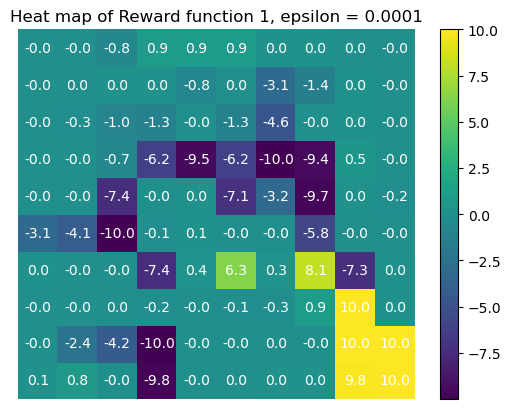

Lambda max for reward 2 is: 0.9218436873747494


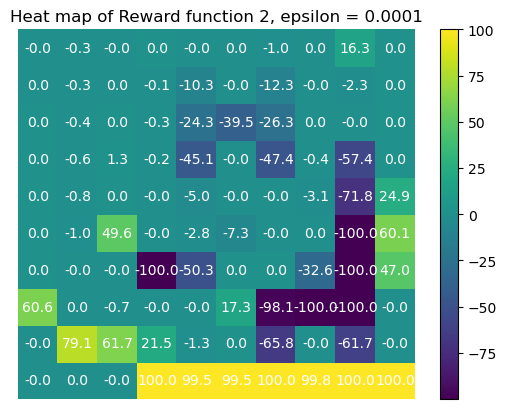

In [134]:
# For reward type 1
lamda_max = lambda_values[np.argmax(accuracies)]
print(f"Lambda max for reward 1 is: {lamda_max}")

reward_predicted_lambda_max, policy_predicted_lambda_max, value_predicted_lambda_max = irl_solver.solve(lamda_max)

heat_map_plot(reward_predicted_lambda_max.reshape(10, 10, order='F'), title=f'Heat map of Reward function 1, epsilon = 0.0001')

# For reward type 2 
lamda_max_r2 = lambda_values_r2[np.argmax(accuracies_r2)]
print(f"Lambda max for reward 2 is: {lamda_max_r2}")

reward_predicted_lambda_max_r2, policy_predicted_lambda_max_r2, value_predicted_lambda_max_r2 = irl_solver_r2.solve(lamda_max_r2)

heat_map_plot(reward_predicted_lambda_max_r2.reshape(10, 10, order='F'), title=f'Heat map of Reward function 2, epsilon = 0.0001')

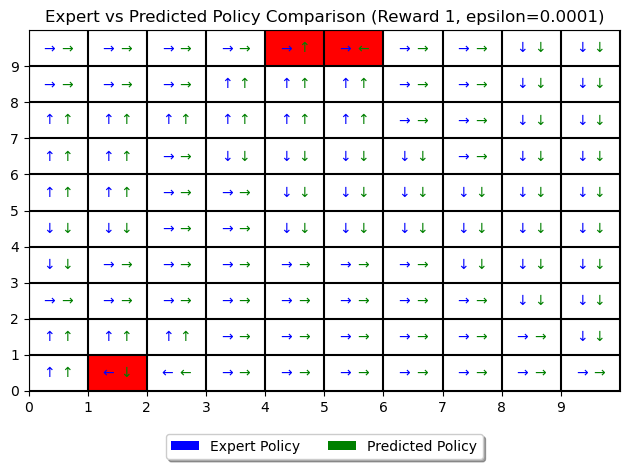

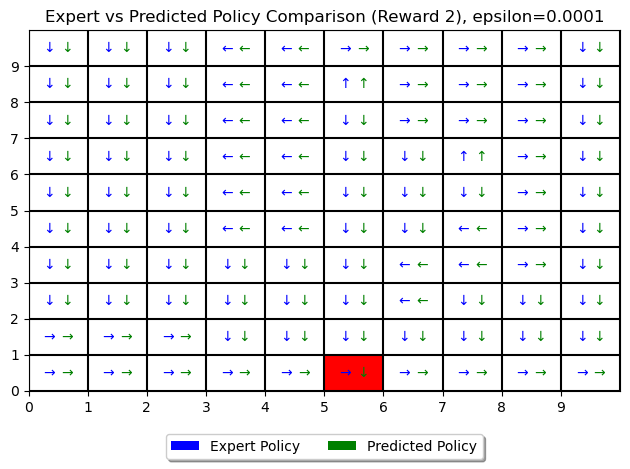

In [135]:
# For reward type 1
compare_policies(irl_solver.expert_policy, policy_predicted_lambda_max,
                title="Expert vs Predicted Policy Comparison (Reward 1, epsilon=0.0001)", 
                policy1_label="Expert Policy",
                policy2_label="Predicted Policy")

# For reward type 2
compare_policies(irl_solver_r2.expert_policy, policy_predicted_lambda_max_r2,
                title="Expert vs Predicted Policy Comparison (Reward 2), epsilon=0.0001",
                policy1_label="Expert Policy", 
                policy2_label="Predicted Policy")

**P.S: The 0, 0 state is still top left.**

## Report

The two major discrepencies are in the 5, 9 and also the bottom part where the predicted policy makes the agent go to off-grid.

For the 5, 9: the neigbors have near values as the state itself. As a result, with loose thereshold, the algorithm can have a less accurate update step and prefers to make the agent to stay in its state. the lagorithm basecally only observes the neighbors for the update. We can fix this by lowering the epsilon value and the accuracies is shown in the plots in this section.

For the bottom states, we see that the states are in the region of very high values. The prediction could not identify the discreteness of the ground truth beforehand.

As a result, because of the LP that may cosider the small but positive rewards/ values optimal, the oversimplification of the LP, LP-IRL minimum-norm objective which has smoothed the reward peaks and increased the high value/ reward states, and the loose thereshold, the prediction can get inaccurate.

We have lowered the epsilon to 0.001 and we see improvements in the predictions. Also the accuracy has increases according to the plots and it is near 100%. 